## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped

import sys

from utils_notebooks import *
import cv2
import os


In [2]:
## THIS PATH MUST BE SET BY USER ()

#_path_xml = "/home/oscar/Codes/ycb_ws/src/robot_object_views/robotobject/models/MODEL_NAME/model-1_4.sdf"
#_path_model = "/home/oscar/Codes/ycb_ws/src/robot_object_views/robotobject/models"   Tenshi Version


_path_model = "/home/oscar/Codes/catkin_mio_ws/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 
_path_xml = _path_model+"/MODEL_NAME/model-1_4.sdf"  #Catkin mio version


model_database_template = """<sdf version="1.4">
  <world name="default">
    <include>
      <uri>model://MODEL_NAME</uri>
    </include>
  </world>
</sdf>"""

objs=os.listdir(_path_model)
objs.sort()



rvizを起動します．ロボットモデル、カメラ映像、ポイントクラウドが表示されています。

In [3]:

rospy.init_node("recognition")


In [4]:
rgbd = RGBD()

In [5]:
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
import moveit_commander
import moveit_msgs.msg

head = moveit_commander.MoveGroupCommander('head')

Launch RViz. The robot model, camera image, and point cloud are displayed:

In [6]:
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)

# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node



In [7]:
def move_base(x,y,th, ref='map'):
    # input goal pose
    goal_x = x
    goal_y = y
    goal_yaw =th

    # fill ROS message
    goal = PoseStamped()
    goal.header.stamp = rospy.Time.now()
    goal.header.frame_id = ref
    goal.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    goal.pose.orientation = Quaternion(*quat)
    # publish ROS message
    pub.publish(goal)
    

In [8]:
move_base(1.14,0.86,1.57)

In [122]:
#moveit
#MOVE IT MUST BE RUNNING. DECLARE A HEAD POSE
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)
#WATCH OUT FOR JOINTS LIMITS (exorcist joke)
#plan and execute target pose
head.set_joint_value_target(head_val)
head.go()

trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
#trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_link', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

trans, euler

([0.9716917583183499, 0.5746324309287307, 0.9858022110030429],
 (-4.8965811411141055e-12, 0.7830089697521297, 1.5149871445520837))

In [123]:
trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
#trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_link', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)


trans, np.rad2deg(euler)

([0.9716917583183499, 0.5746324309287307, 0.9858022110030429],
 array([-2.80553433e-10,  4.48631093e+01,  8.68023694e+01]))

In [124]:
def cart2spher(x,y,z):
    ro= np.sqrt(x**2+y**2+z**2)
    th=np.arctan2(y,x)
    phi=np.arctan2((np.sqrt(x**2+y**2)),z)
    return np.asarray((ro,th,phi))
def spher2cart(ro,th,phi):
    x= ro * np.cos(th)* np.sin(phi)
    y= ro * np.sin(th)* np.sin(phi)
    z= ro*  np.cos(th)
    return np.asarray((x,y,z))

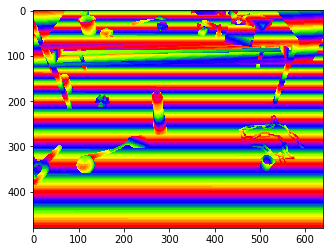

In [125]:
# ポイントクラウドを取得します Get point cloud information
points_data = rgbd.get_points()
# ポイントクラウドの深度情報を表示してみます Display the depth value of the point cloud information
plt.imshow(points_data['z'], cmap='prism')

In [135]:
px_y,px_x=-1,-200
P1= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))

px_y,px_x=-1,200
P2= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))

px_y,px_x=-150,320
P3= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))

px_y,px_x=1,320
P4= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
P1,P2,P3 , P4

(array([0.20977442, 0.41693753, 0.9651063 ], dtype=float32),
 array([-0.2080138 ,  0.41689795,  0.9650147 ], dtype=float32),
 array([1.0712785e-03, 1.9390139e-01, 1.1877965e+00], dtype=float32),
 array([ 1.2905828e-03, -6.1560804e-01,  1.4309536e+00], dtype=float32))

In [136]:
V1 =P1 - P2
V2= P3-P2
nx,ny,nz=np.cross(V2,V1)
print('look at the phi angle  in normal vector', np.rad2deg(cart2spher(nx,ny,nz))[2]-90)
print ('cartesian Normal floor',nx,ny,nz)
#plane angle to be found is same slope as the camera 

np.rad2deg(euler)[1]

#OR ELSE

('look at the phi angle  in normal vector', -45.03604658785134)
('cartesian Normal floor', -2.924638e-05, 0.09305644, 0.09317361)


44.86310928768377

In [138]:
#check if P4  its in floor plane
#normal vector = np.cross(V2,V1)
##vectors from known floor points
##P0= P1
## 0 = \vec{n} \dot \vec{P_0P}
np.dot(np.asarray((nx,ny,nz,)),P4-P1)
## if not 0 (or almost )

-0.052674238

In [139]:




ind=0
quat=rot


In [140]:
x,y,z=P1
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P1',"head_rgbd_sensor_link")
x,y,z=P2
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P2',"head_rgbd_sensor_link")
x,y,z=P3
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P3',"head_rgbd_sensor_link")
x,y,z=P4
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P4',"head_rgbd_sensor_link")

In [141]:

trans , rot = listener.lookupTransform('/map', '/P1', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 1 wrt map',trans, np.rad2deg(euler))
trans , rot = listener.lookupTransform('/map', '/P2', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 2 wrt map',trans, np.rad2deg(euler))
trans , rot = listener.lookupTransform('/map', '/P3', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 3 wrt map',trans, np.rad2deg(euler))
trans , rot = listener.lookupTransform('/map', '/P4', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 4 wrt map',trans, np.rad2deg(euler))
gazebo_2_world

('point 1 wrt map', [1.0626616655693117, 1.0070518955344254, 0.007936652331692716], array([-1.77741323e+02,  4.65614579e-02, -9.14224728e+01]))
('point 2 wrt map', [0.6457294936294888, 1.0338940934692211, 0.008029439684152371], array([-1.77741323e+02,  4.65621687e-02, -9.14224678e+01]))
('point 3 wrt map', [0.8746589303291513, 1.3350038104618607, 0.007930144699715534], array([-1.77741323e+02,  4.65621687e-02, -9.14224678e+01]))
('point 4 wrt map', [0.9227816637429813, 2.078113838324908, 0.4078084352706102], array([-1.77741323e+02,  4.65621687e-02, -9.14224678e+01]))


<function utils_notebooks.gazebo_2_world>

In [142]:
#moveit
#MOVE IT MUST BE RUNNING. DECLARE A HEAD POSE
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)###Might be usefull to play this numbers
head_val[1]=np.deg2rad(-45)
#WATCH OUT FOR JOINTS LIMITS (exorcist joke)
#plan and execute target pose
head.set_joint_value_target(head_val)
head.go()

trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
#trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_link', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

trans, euler

([0.8263126920519096, 0.6353606777981271, 0.9855020955134223],
 (-4.89655270381172e-12, 0.7861481192109993, 1.5063592764391114))

In [143]:
mask=np.zeros((image_data.shape))
plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))


In [144]:
mask[:,:,0]=points_data['x'] - P1[0]
mask[:,:,1]=points_data['y'] - P1[1]
mask[:,:,2]=points_data['z'] - P1[2]

In [145]:
for i in range (image_data.shape[0]):
    for j in range (image_data.shape[1]):
        plane_mask[i,j]=-np.dot(np.asarray((nx,ny,nz,)),mask[i,j])

In [146]:
plane_mask=plane_mask-np.min(plane_mask)
plane_mask=plane_mask*256/np.max(plane_mask)
plane_mask.shape

(480, 640)

In [147]:
plane_mask.astype('uint8')
plane_mask.shape

(480, 640)

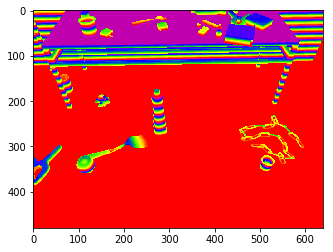

In [148]:
plt.imshow(plane_mask , cmap='prism')

In [149]:
plane_mask[200,1], plane_mask[-1,1],plane_mask[1,1]

(0.00010497560008429404, 0.00022430190680130496, 206.84646420878704)

In [150]:
plane_mask.shape


(480, 640)

In [151]:
ret,thresh = cv2.threshold(plane_mask,3,255,0)


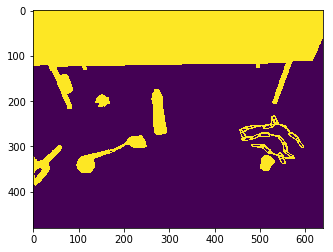

In [152]:
#FLOOR MASK
plt.imshow(thresh) 

In [153]:
move_base(0,0,1.57)

In [98]:
###Run again the appropriate blocks to try to look for legos on the way


###CAn you navigate through?

### Can we pick em up?


#PLEASE TRY THINGS HERE